### TransUnet

In [14]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from self_attention_cv.transunet import TransUnet

from OverlayerTransformer import Overlayer

import numpy as np
import einops

import matplotlib.pyplot as plt
from PIL import Image

import os
import fnmatch
import ntpath
import random


import random
import yaml
import glob
import numpy as np
import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from scipy import ndimage

import seaborn as sns

In [15]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [16]:
def collect_paths(treeroot, pattern):
    results = []
    for base, _, files in os.walk(treeroot):
        goodfiles = fnmatch.filter(files, pattern)
        results.extend(os.path.join(base, f) for f in goodfiles)

    return sorted(results)

def get_train_test_idxs(paths, coeff=0.95) -> (list, list):
    amount = round(len(paths) * train_subset_coeff)
    idxs = list(range(len(paths)))
    random.shuffle(idxs)
    
    return idxs[:amount], idxs[amount:]

class MinMaxNormalize:
    """Implementation of min-max normalization.
    """
    def __call__(self, sample):
        assert isinstance(sample, (torch.Tensor, np.ndarray)), "arg must be a torch.Tensor or np.ndarray"

        return (sample - sample.min()) / (sample.max() - sample.min())


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    MinMaxNormalize()
])


class XRayRenderSet(Dataset):
    def __init__(self, mask_paths, image_paths, transform):
        self.mask_paths = mask_paths
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.mask_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        original_image = MinMaxNormalize()( transforms.ToTensor()( image ) )
        image = self.transform(image)
        image = image.type(torch.float32)
        
        mask = Image.open(self.mask_paths[idx])
        mask = self.transform(mask)
        mask = mask.type(torch.float32)
        
        return original_image, image, mask


# class XRaySet(Dataset):
#     def __init__(self, mask_paths, image_paths, transform):
#         self.mask_paths = mask_paths
#         self.image_paths = image_paths
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.mask_paths)
    
#     def __getitem__(self, idx):
#         image = Image.open(self.image_paths[idx])
#         image = self.transform(image)
#         image = image.type(torch.float32)
        
#         mask = Image.open(self.mask_paths[idx])
#         mask = self.transform(mask)
#         mask = mask.type(torch.float32)
        
#         return image, mask

class XRaySet(Dataset):
    def __init__(self, mask_paths, image_paths, name="with_overlayer"):
        self.mask_paths = mask_paths
        self.image_paths = image_paths
        self.name = name
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256, 256)),
            MinMaxNormalize()
        ])
                
        self.overlayer = Overlayer(
            masks_path="",
            preps_path="",
            anomalies_path="/home/student/Documents/Xrays/Data/anomalies",
            anml_amount_max=4,
            probability=90,
            anomaly_min_pxl_intensity=750,
            anomaly_max_pxl_intensity=2200,  # 6000
            min_points_amount=3,
            max_points_amount=9,
            max_polygons_amount=5
        )

        
    def __len__(self):
        return len(self.mask_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx])
        
        # Overlayer
        payload = {"image": np.array(image), "label": np.array(mask)>0, "name": self.image_paths[idx]}
        image, mask, name = self.overlayer(payload).values()
        mask = mask * 1
        
        image = self.transform(image)
        image = image.type(torch.float32)
        
        mask = self.transform(mask)
        mask = mask.type(torch.float32)
        
        return image, mask, self.image_paths[idx]
    
def show(x):
    x = einops.rearrange(
        x,
        "b c h w -> (b c h) w"
    )

    x = (x.cpu().detach().numpy() * 255).astype(np.uint8)
    
    return x

def intensity(image, bool_mask, values):
    """ Highlights the masked part of the image
    """
    image = np.stack([image, image, image], axis=2)
    
    if isinstance(values, int):
        values = (values, values, values)

    for ind,v in enumerate(values):
        channel = np.where(~bool_mask, image[:, :, ind], image[:, :, ind] - v)
        channel[channel<0] = 0
        image[:, :, ind] = channel.astype(int)

    return image

In [17]:
batch_size = 1
train_subset_coeff = 0.95

img_path = "/home/student/Documents/Xrays/Data/preprocessed_images_train/"
mask_path = "/home/student/Documents/Xrays/Data/masks_train/"
# mask_path = "/home/student/Documents/xrays/data/updated_masks_v1/"

img_paths = collect_paths(img_path, "*.png")
mask_paths = collect_paths(mask_path, "*.png")

# Cut masks with has no corresponding images
names = [ntpath.split(i)[1] for i in img_paths]
mask_paths = [i for i in mask_paths if ntpath.split(i)[1] in names]

# Cut imgs with has no corresponding masks
names = [ntpath.split(i)[1] for i in mask_paths]
img_paths = [i for i in img_paths if ntpath.split(i)[1] in names]

# Cut masks with has no corresponding images
names = [ntpath.split(i)[1] for i in img_paths]
mask_paths = [i for i in mask_paths if ntpath.split(i)[1] in names]

train_idxs, test_idxs = get_train_test_idxs(img_paths)

In [18]:
print(f"{len(img_paths)}, {len(mask_paths)}")

1653, 1653


In [19]:
train_image_paths = [img_paths[ind] for ind in train_idxs]
train_mask_paths  = [mask_paths[ind] for ind in train_idxs]

test_image_paths = [img_paths[ind] for ind in test_idxs]
test_mask_paths  = [mask_paths[ind] for ind in test_idxs]

train_dataset = XRaySet(image_paths=train_image_paths, mask_paths=train_mask_paths)
test_dataset = XRaySet(image_paths=test_image_paths, mask_paths=test_mask_paths)
# render_dataset = XRayRenderSet(image_paths=test_image_paths, mask_paths=test_mask_paths)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
# render_dataloader = DataLoader(render_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

In [20]:
model = TransUnet(
    in_channels=1,
    img_dim=256,
    vit_blocks=8,  # было 8
    vit_dim_linear_mhsa_block=512,
    classes=1
)

model = model.cuda() #.cuda()

In [21]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print("Trainable parameters amount: {:n}".format(params))

Trainable parameters amount: 67076987


In [22]:
# lr: from 0.01 to 0.00015625 in 10,000 epoches
# optimizer = torch.optim.SGD(model.parameters(), lr=0.03)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1700, gamma=0.5)

criterion = torch.nn.BCELoss()
# criterion = DiceLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 500  # ~50.3s на эпоху -> 100 часов -> 4 дня

verbose = 1
save_step = 10

In [23]:
# t_output.mean(), t_output.max(), t_output.min(), torch.quantile(t_output.flatten(), torch.tensor([0.01]).cuda())

In [24]:
# with open("test_idxs.txt", "w") as file:
#     file.write(" ".join(map(str, test_idxs)))

In [ ]:
%%time
losses = []
for epoch in range(num_epochs):
    loss_accumulator = []
    
    for ind,data in enumerate(train_dataloader):
        images, masks, _ = data
        masks = (masks==0).type(torch.float32)
        images = images.cuda()
        masks = masks.cuda()
        
        output = model(images)
        output = torch.sigmoid(output)
            
        optimizer.zero_grad()
        
        # Don't forget about -1 if you are using SSIM-like losses!
        loss = criterion(output, masks)
        diff = loss.item()
        
        loss.backward()
        optimizer.step()
        # scheduler.step()       
        loss_accumulator.append(diff)
        
    losses.append(np.mean(loss_accumulator))
        
    if (epoch + 1) % save_step == 0:
        torch.save(model.state_dict(), f"transunet_{epoch+1}epo_bce_vit8_vitdim512_ovrl.meow")
        print(f"Saved: transunet_{epoch+1}epo_bce_vit12_vitdim512_ovrl.meow")
           
    print('epoch [{}/{}], loss: {:.5f}'.format(epoch+1, num_epochs, np.mean(loss_accumulator)))
    
    # with open("losses.txt", "a+") as file:
    #     file.write('epoch [{}/{}], loss: {:.5f}\n'.format(epoch+1, num_epochs, np.mean(loss_accumulator)))

epoch [1/500], loss: 0.13837


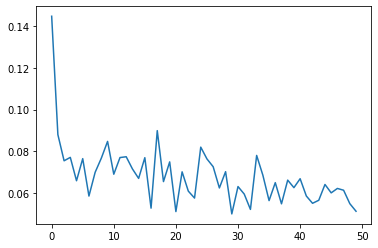

In [13]:
plt.plot(losses)

In [15]:
(29*60+47) / 31

57.645161290322584

In [16]:
(13*60*60+30*60) / 57.7

842.2876949740034

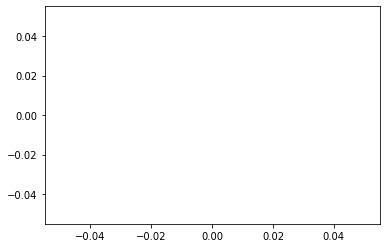

In [17]:
plt.plot(losses)

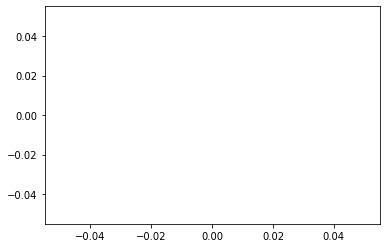

In [18]:
plt.plot(losses)

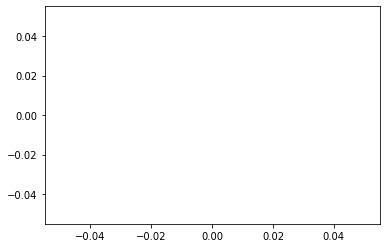

In [19]:
plt.plot(losses)

epoch [1/30], loss: 0.42828
epoch [2/30], loss: 0.37059
epoch [3/30], loss: 0.35071
epoch [4/30], loss: 0.32700
Saved: transunet_5epo_bce_vit8_vitdim256.meow
epoch [5/30], loss: 0.31135
epoch [6/30], loss: 0.29856
epoch [7/30], loss: 0.28396
epoch [8/30], loss: 0.26057
epoch [9/30], loss: 0.26356
Saved: transunet_10epo_bce_vit8_vitdim256.meow
epoch [10/30], loss: 0.24245
epoch [11/30], loss: 0.23714
epoch [12/30], loss: 0.21383
epoch [13/30], loss: 0.19779
epoch [14/30], loss: 0.20835
Saved: transunet_15epo_bce_vit8_vitdim256.meow
epoch [15/30], loss: 0.18336
epoch [16/30], loss: 0.18966
epoch [17/30], loss: 0.17860
epoch [18/30], loss: 0.15628
epoch [19/30], loss: 0.16570
Saved: transunet_20epo_bce_vit8_vitdim256.meow
epoch [20/30], loss: 0.16073
epoch [21/30], loss: 0.14952
epoch [22/30], loss: 0.12689
epoch [23/30], loss: 0.14336
epoch [24/30], loss: 0.10324
Saved: transunet_25epo_bce_vit8_vitdim256.meow
epoch [25/30], loss: 0.11761
epoch [26/30], loss: 0.14241
epoch [27/30], loss: 0.12212
epoch [28/30], loss: 0.18332
epoch [29/30], loss: 0.11499
Saved: transunet_30epo_bce_vit8_vitdim256.meow
epoch [30/30], loss: 0.09774
CPU times: user 1h 6min 14s, sys: 24.8 s, total: 1h 6min 39s
Wall time: 24min 25s

In [20]:
# for ind, data in enumerate(render_dataloader):
#     original, t_images, t_masks = data
#     t_images = t_images.cuda()
#     t_masks = t_masks.cuda()

#     t_output = model(t_images)
#     t_output = torch.sigmoid(t_output)
    
#     threshold = torch.quantile(t_output.flatten(), torch.tensor([0.01]).cuda())
#     t_output = (t_output > threshold).type(torch.float32)
        
    
#     if ind % 15 == 0 and ind != 0:
#         break

In [21]:
50.3 * 30 / 60

25.15

In [22]:
def min_max(x):
    return (x - x.min()) / (x.max() - x.min())

def tr(x):
    return min_max(x) * 255

In [23]:
def analyze(source):
    if type(source) == str:
        me_arr = Image.open(source).convert('L')
        me_arr = transform(me_arr).cpu()
        me_arr = me_arr.type(torch.float32)

        me_arr = einops.rearrange(me_arr, "(b c) h w -> b c h w", b=1)
    else:
        arr, me_arr, mask = source
        
        # print(arr.shape)

        # t_output = model(arr)
        # t_output = torch.sigmoid(t_output)
        # t_output = show(t_output)
        
        
    
    me_output = model(me_arr.cpu())
    me_output = torch.sigmoid(me_output)
    
    me_output = show(me_output)
    me_output = me_output < 55 # model.load_state_dict(torch.load(PATH))# me_output.mean()
    
    if type(source) == str:
        me_output_mask = transforms.Resize(Image.open(source).size[::-1])(Image.fromarray(me_output))
        
        return Image.fromarray(
            intensity(
                (MinMaxNormalize()(np.array(Image.open(source).convert("L"))) * 255).astype(np.uint8),
                np.array(me_output_mask), (20, 20, 0)
            )
        )
    else:
        me_output_mask = me_output #transforms.Resize(source.shape)(Image.fromarray(me_output))
        me_output_mask = transforms.Resize(arr.shape[-2:])(Image.fromarray(me_output_mask))
        mask = transforms.Resize(arr.shape[-2:])(Image.fromarray(mask.numpy()[0, 0, :]))
        
        # return 
        
        tmp = (MinMaxNormalize()(arr) * 255).numpy().astype(np.uint8)[0, ]
        tmp = g_to_rgb(tmp)[0, :]
        tmp = einops.rearrange(tmp, "c h w -> h w c")
            
        # tmp = intensity(
        #         (MinMaxNormalize()(arr) * 255).numpy().astype(np.uint8),
        #         np.array(me_output_mask), (120, 120, 0)
        #     )[0, 0, :, :, :] #.astype(np.uint8)
            
        # tmp = Image.fromarray(einops.rearrange(tmp, "c h w -> h w c"))
        
        # img = g_to_rgb(torch.from_numpy(show(t_images)))
        # msk = me_output_mask == 255
        
        msk = transforms.ToTensor()(me_output_mask) != 0.
        msk_original = transforms.ToTensor()(mask) != 0.

        r = dsm(image=(transforms.ToTensor()(tmp)*255).type(torch.uint8), masks=msk, alpha=0.5, colors="#20a7c8").numpy()
        r = einops.rearrange(r, "c h w -> h w c")
        r = Image.fromarray(r).convert('RGB')
                
        return r, me_output_mask, arr, msk_original[0, :], msk[0, :]

In [24]:
analyze('/home/student/Documents/xrays/avatar105858661-0.jpg') #.save("example_4.png")

FileNotFoundError: [Errno 2] No such file or directory: '/home/student/Documents/xrays/avatar105858661-0.jpg'

In [ ]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, sigma, channel):
    _1D_window = gaussian(window_size, sigma).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

class MS_SSIM(torch.nn.Module):
    def __init__(self, size_average = True, max_val = 255):
        super(MS_SSIM, self).__init__()
        self.size_average = size_average
        self.channel = 1
        self.max_val = max_val
    def _ssim(self, img1, img2, size_average = True):

        _, c, w, h = img1.size()
        window_size = min(w, h, 11)
        sigma = 1.5 * window_size / 11
        window = create_window(window_size, sigma, self.channel).cuda()
        mu1 = F.conv2d(img1, window, padding = window_size//2, groups = self.channel)
        mu2 = F.conv2d(img2, window, padding = window_size//2, groups = self.channel)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1*mu2

        sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = self.channel) - mu1_sq
        sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = self.channel) - mu2_sq
        sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = self.channel) - mu1_mu2

        C1 = (0.01*self.max_val)**2
        C2 = (0.03*self.max_val)**2
        V1 = 2.0 * sigma12 + C2
        V2 = sigma1_sq + sigma2_sq + C2
        ssim_map = ((2*mu1_mu2 + C1)*V1)/((mu1_sq + mu2_sq + C1)*V2)
        mcs_map = V1 / V2
        if size_average:
            return ssim_map.mean(), mcs_map.mean()

    def ms_ssim(self, img1, img2, levels=5):

        weight = Variable(torch.Tensor([0.0448, 0.2856, 0.3001, 0.2363, 0.1333]).cuda())

        msssim = Variable(torch.Tensor(levels,).cuda())
        mcs = Variable(torch.Tensor(levels,).cuda())
        for i in range(levels):
            ssim_map, mcs_map = self._ssim(img1, img2)
            msssim[i] = ssim_map
            mcs[i] = mcs_map
            filtered_im1 = F.avg_pool2d(img1, kernel_size=2, stride=2)
            filtered_im2 = F.avg_pool2d(img2, kernel_size=2, stride=2)
            img1 = filtered_im1
            img2 = filtered_im2

        value = (torch.prod(mcs[0:levels-1]**weight[0:levels-1])*
                                    (msssim[levels-1]**weight[levels-1]))
        return value


    def forward(self, img1, img2):

        return self.ms_ssim(img1, img2)
    

ms_ssim = MS_SSIM()
ms_ssim = ms_ssim.cuda()

In [ ]:
test_losses = {"mean": [], "min": 1, "max": 0}
test_losses_2 = {"mean": [], "min": 1, "max": 0}
for ind, data in enumerate(render_dataloader):
#     original, t_images, t_masks = data
#     t_images = t_images.cuda()
#     t_masks = t_masks.cuda()
#     t_output = model(t_images)
#     t_output = torch.sigmoid(t_output)
#     threshold = torch.quantile(t_output.flatten(), torch.tensor([0.01]).cuda())
#     t_output = (t_output > threshold).type(torch.float32)
        
#     if ind % 120 == 0 and ind != 0:
#         break

    test_loss = IoU(analyze(data)[3], analyze(data)[4]).item()
    test_losses["mean"].append(test_loss)
    if test_losses["min"] >= test_loss:
        test_losses["min"] = test_loss
    if test_losses["max"] <= test_loss:
        test_losses["max"] = test_loss
        
    a = ms_ssim(einops.rearrange(analyze(data)[3], "(b c h) w -> b c h w", b=1, c=1).cuda()*1., einops.rearrange(analyze(data)[4].cpu(), "(b c h) w -> b c h w", b=1, c=1).cuda()*1.) #.item()
    a = a.item()
    test_losses_2["mean"].append(a)
    if test_losses_2["min"] >= a:
        test_losses_2["min"] = a
    if test_losses_2["max"] <= a:
        test_losses_2["max"] = a
        
test_losses_2["mean"] = np.mean(test_losses_2["mean"])
test_losses["mean"] = np.mean(test_losses["mean"])

In [ ]:
print(f'IOU    : {test_losses["mean"]=}, {test_losses["min"]=}, {test_losses["max"]=}')
print(f'MS-SSIM: {test_losses_2["mean"]=}, {test_losses_2["min"]=}, {test_losses_2["max"]=}')

In [ ]:
IoU(analyze(data)[3], analyze(data)[4])

In [ ]:
from functools import reduce
def IoU(*masks) -> float:
    e = 1e-6
    return (reduce(torch.logical_and, masks).sum() + e) / \
           (reduce(torch.logical_or, masks).sum() + e)

In [ ]:
analyze(data)[0] #.save("example_4.png")

In [ ]:
device = torch.device('cpu')
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH, map_location=device))

model.load_state_dict(torch.load("transunet_80epo_bce_vit8.meow", map_location=device))

In [ ]:
from torchvision.utils import draw_segmentation_masks as dsm

In [ ]:
def g_to_rgb(image):
        """ Convert grayscale to rgb image
        (add two identical channels)
        """
        return np.stack([image, image, image], axis=1)

In [ ]:
g_to_rgb(torch.from_numpy(show(t_images))).shape, torch.from_numpy(show(t_output)).unsqueeze(0).shape

In [ ]:
plt.imshow(einops.rearrange(r, "c h w -> h w c"))

In [ ]:
img = g_to_rgb(torch.from_numpy(show(t_images)))
msk = torch.from_numpy(show(t_output)) == 255

r = dsm(image=img, masks=msk, alpha=0.3).numpy()
r = einops.rearrange(r, "c h w -> h w c")
rr = Image.fromarray(r)
rr = rr.convert('RGB')
rr

In [ ]:
analyze(data)[0] #.save("presentation2.png")
# analyze(data).save("res70_wow.png")

In [ ]:
me = "/home/student/Downloads/me5.png"
girl = "/home/student/Downloads/girl5.png"
giant = "/home/student/Downloads/giant5.png"

In [ ]:
Image.fromarray(
    intensity(
        (MinMaxNormalize()(np.array(Image.open(giant))) * 255).astype(np.uint8),
        np.array(me_output_mask), (20, 20, 0)
    )
)

In [ ]:
Image.fromarray(
    intensity(np.array(Image.open(giant)), np.array(me_output_mask), 20).astype(np.uint16)
)

In [ ]:
Image.open(giant).size

In [ ]:
me_arr

In [ ]:
plt.figure(figsize=(12, 4))
sns.scatterplot(x=range(len(losses)), y=losses, color="#036aea", s=15, label="Loss value", marker="o")
sns.lineplot(x=range(len(losses)), y=losses, color="#4da9de")
plt.legend(prop={'size': 13})
plt.xlabel("epoches", fontsize=13)
plt.ylabel("loss value", fontsize=13)
# plt.show()
plt.savefig("losses.jpg")

In [ ]:
torch.randint(0, 2, (10, 1))